In [1]:
# # example_continuous_time_linear.py
# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Linear system identification example in continuous time

#             dx(t)/dt = A x(t) + B u(t)
#                 y(t) = C x(t) + D u(t)
#                 x(0) = x0

# (C) 2024 A. Bemporad, December 22, 2024
# """

# from jax_sysid.utils import standard_scale, compute_scores
# from jax_sysid.models import CTModel
# import jax
# import jax.numpy as jnp
# import numpy as np
# import matplotlib.pyplot as plt
# import diffrax
# import control as ctrl

# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations

# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# s = ctrl.TransferFunction.s
# sys = (s + 1)/(s**3 + 3*s**2 +2*s + 1)
# A, B, C, D = ctrl.ssdata(sys)
# nx,nu = B.shape # number of states and inputs
# ny = C.shape[0] # number of outputs

# # Data generation
# def generate_data(Tstop, Ts_u, Ts_y, umin, umax, y_noise, seed):
#     Tu = np.arange(0.,Tstop+Ts_u, Ts_u) # add one more sample to define the interpolation over the entire range of time [0,Tstop]
#     T = np.arange(0.,Tstop, Ts_y) # time at which the output is evaluated

#     # random input excitation
#     np.random.seed(seed)
#     u0=umin+(umax-umin)*np.random.rand()
#     U = np.empty(Tu.shape).reshape(-1,1)
#     for i in range(Tu.size):
#         if np.random.randn()>0.95:
#             u0=umin+(umax-umin)*np.random.rand()
#         U[i] = u0

#     # Evaluate the input signal at the time instants T
#     Tc, Uc = diffrax.rectilinear_interpolation(Tu, U.reshape(-1))
#     input_eval = diffrax.LinearInterpolation(ts=Tc, ys=Uc)
#     U_sim = input_eval.evaluate(T).reshape(-1)
    
#     # Simulate the linear system
#     sim = ctrl.forced_response(sys, T, U_sim)
#     Y=sim.y.reshape(-1,1)
#     T=sim.t.reshape(-1)
    
#     # Add noise
#     Y += y_noise*np.random.randn(Y.size).reshape(-1,1) # add measurement noise
#     return Y, T, U, Tu

# Y_train, T_train, U_train, Tu_train = generate_data(1000., 5., 1., -2., 2., 0.1, 1)
# Y_test, T_test, U_test, Tu_test = generate_data(1000., 5., 1., -2., 2., 0.1, 2)

# # Standardize data
# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)
# Ys_test = (Y_test-ymean)*ygain
# Us_test = (U_test-umean)*ugain

# Us_train = Us_train.reshape(-1,1)
# Ys_train = Ys_train.reshape(-1,1)
# Us_test = Us_test.reshape(-1,1)
# Ys_test = Ys_test.reshape(-1,1)

# @jax.jit
# def state_fcn(x, u, t, params):
#     # This computes dx/dt = f(x,u) for continuous-time systems
#     A, B, C = params
#     return A@x+B@u

# @jax.jit
# def output_fcn(x, u, t, params):
#     A, B, C = params
#     return C@x

# def init_fcn(seed):
#     np.random.seed(seed)
#     A = -np.eye(nx) # start with a stable linear system
#     B = 0.1*np.random.randn(nx, nu)
#     C = 0.1*np.random.randn(ny, nx)
#     return [A, B, C]

# # initialize model coefficients
# model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
# model.integration_options(ode_solver=diffrax.Heun())
# model.init(params=init_fcn(seed=1))
# # L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-4, rho_th=1.e-4, train_x0=True)
# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=100, lbfgs_epochs=2000, adam_eta=0.1)

# # Train from different initializations:
# model.fit(Ys_train, Us_train, T_train, Tu_train)

# x0_train=model.x0 # trained initial state
# Yshat_train, _ = model.predict(x0_train, Us_train, T_train, Tu_train)

# x0_test=model.learn_x0(Us_test, Ys_test, T_test, Tu_test)
# Yshat_test, _ = model.predict(x0_test, Us_test, T_test, Tu_test)

# # Compute scores
# R2_train, R2_test, msg = compute_scores(Ys_train, Yshat_train, Ys_test, Yshat_test)
# print(msg)

# Ah, Bh, Ch = model.params
# Dh = np.zeros((ny, nu))
# sys_hat = ctrl.tf(ctrl.ss(Ah, Bh, Ch, Dh))

# print(f"True system's DC gain       = {ctrl.dcgain(sys)}")
# print(f"Identified system's DC gain = {ctrl.dcgain(sys_hat)}")

# # Plot results
# fig, ax = plt.subplots(2, 1, figsize=(10, 6))
# ax[0].plot(Tu_train, Us_train, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
# ax[0].plot(T_train, Ys_train, label='True output')
# ax[0].plot(T_train, Yshat_train, label='Predicted output')
# ax[0].set_title('Training data')
# ax[0].legend()
# ax[0].grid()
# ax[0].set_xlabel('Time')
# ax[1].plot(Tu_test, Us_test, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
# ax[1].plot(T_test, Ys_test, label='True output')
# ax[1].plot(T_test, Yshat_test, label='Predicted output')
# ax[1].set_title('Test data')
# ax[1].legend()
# ax[1].grid()
# ax[1].set_xlabel('Time')


In [4]:
# example_continuous_time_mimo.py
"""
jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

Nonlinear system identification example in continuous time using a multi-input multi-output Wiener model

            dx(t)/dt = Ax(t) + Bu(t)
                y(t) = fy(Cx(t))

(C) 2024 A. Bemporad, December 23, 2024
"""

from jax_sysid.utils import standard_scale, compute_scores
from jax_sysid.models import CTModel, LinearModel
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import diffrax
from joblib import cpu_count

jax.config.update('jax_platform_name', 'cpu')
if not jax.config.jax_enable_x64:
    jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations

seed = 3  # for reproducibility of results
np.random.seed(seed)

nx = 3  # number of states
ny = 2  # number of outputs
nu = 2  # number of inputs

# Data generation - Generate data from a discrete-time model
N_train = 500  # number of training data
N_test = 500  # number of test data
Ts = 5.0  # sample time

At = np.diag(np.array([.98,.95,.92]))
Bt = np.random.randn(nx, nu)
Ct = np.random.randn(ny, nx)
Dt = np.zeros((ny, nu))  # no direct feedthrough
truemodel = LinearModel(nx, ny, nu, feedthrough=False)
# truemodel.ss(feedthrough=False) # make model a linear state-space model without direct feedthrough
truemodel.init(params=[At, Bt, Ct])
def nonlinearity(y):
    return y*(1.+.5*np.sin(y/2.))
x0=np.zeros(nx)
U_train = np.random.randn(N_train, nu)
Y_train = nonlinearity(truemodel.predict(x0, U_train)[0])
Y_train += 0.0*np.random.randn(N_train, ny)  # add noise
T_train = np.arange(0.,N_train*Ts,Ts)

U_test = np.random.randn(N_test, nu)
Y_test = nonlinearity(truemodel.predict(x0, U_test)[0])
Y_test += 0.0*np.random.randn(N_test, ny)  # add noise
T_test = np.arange(0.,N_test*Ts,Ts)

Ys_train, ymean, ygain = standard_scale(Y_train)
Us_train, umean, ugain = standard_scale(U_train)

Ys_test = (Y_test-ymean)*ygain
Us_test = (U_test-umean)*ugain

Ys_train = Ys_train.reshape(-1,ny)
Ys_test = Ys_test.reshape(-1,ny)

# Perform system identification
def activation(x):
    return x / (1. + jnp.exp(-x))
    #return jnp.maximum(0., x)

@jax.jit
def state_fcn(x, u, t, params):
    # This computes dx/dt = f(x,u) for continuous-time systems
    A, B, C1, C2, C3, b1, b2 = params
    return A@x+B@u

@jax.jit
def output_fcn(x, u, t, params):
    A, B, C1, C2, C3, b1, b2 = params
    return C1@activation(C2@x+b1)+C3@x+b2

nny = 20  # number of hidden neurons in output nonlinearity

def init_fcn(seed):
    np.random.seed(seed)
    A = -np.eye(nx) # start with a stable linear system
    B = np.random.randn(nx, nu)     
    C1 = .1*np.random.randn(ny, nny)
    C2 = .1*np.random.randn(nny, nx)
    C3 = np.random.randn(ny, nx)
    b1 = np.zeros(nny)
    b2 = np.zeros(ny)
    
    return [A, B, C1, C2, C3, b1, b2]


# initialize model coefficients
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
model.integration_options(ode_solver=diffrax.Heun(), dt0=0.5)
model.init(params=init_fcn(seed=1))
# L2-regularization on initial state and model coefficients
model.loss(rho_x0=1.e-4, rho_th=1.e-4, train_x0=True) # default loss: integral of squared output prediction errors
# number of epochs for Adam and L-BFGS-B optimization
model.optimization(adam_epochs=1000, lbfgs_epochs=3000)

# Fit model to training data
single_fit = False
if single_fit:
    model.fit(Ys_train, Us_train, T_train)
else:
    # Train from different initializations:
    models = model.parallel_fit(Ys_train, Us_train, T_train, init_fcn=init_fcn, seeds=range(cpu_count()))
    R2 = model.find_best_model(models, Ys_train, Us_train, T_train)

x0_train=model.learn_x0(Us_train, Ys_train, T_train)
Yshat_train, Xhat_train = model.predict(x0_train, Us_train, T_train)

x0_test=model.learn_x0(Us_test, Ys_test, T_test)
T_test = np.arange(0.,T_test.size*Ts,Ts)
Yshat_test, _ = model.predict(x0_test, Us_test, T_test)

# Compute scores
R2_train, R2_test, msg = compute_scores(Ys_train, Yshat_train, Ys_test, Yshat_test)
print(msg)

# Plot results
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
for k in range(2):
    str = 'training' if k==0 else 'test'    
    for j in range(2):
        ax[k,j].plot(T_train, Us_train, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
        ax[k,j].plot(T_train, Ys_train[:,j], label=fr'{str} - $y_{j+1}$')
        ax[k,j].plot(T_train, Yshat_train[:,j], label=fr'{str} - $\hat y_{j+1}$')
        ax[k,j].legend()
        ax[k,j].grid()
        ax[k,j].set_xlabel('Time')



Evaluating models...



AssertionError: 

Evaluating models...

Scores:
Model 0: R2 = 99.93230765821262
Model 1: R2 = 99.92979409724015
Model 2: R2 = 99.93150126120135
Model 3: R2 = 99.92986766112092
Model 4: R2 = 99.9283085646829
Model 5: R2 = 99.92821534245535
Model 6: R2 = 99.9272235496058
Model 7: R2 = 99.94416114925286
Best model: 7, score: 99.94416114925286
R2 score:  training =  99.9442, test =  99.9603


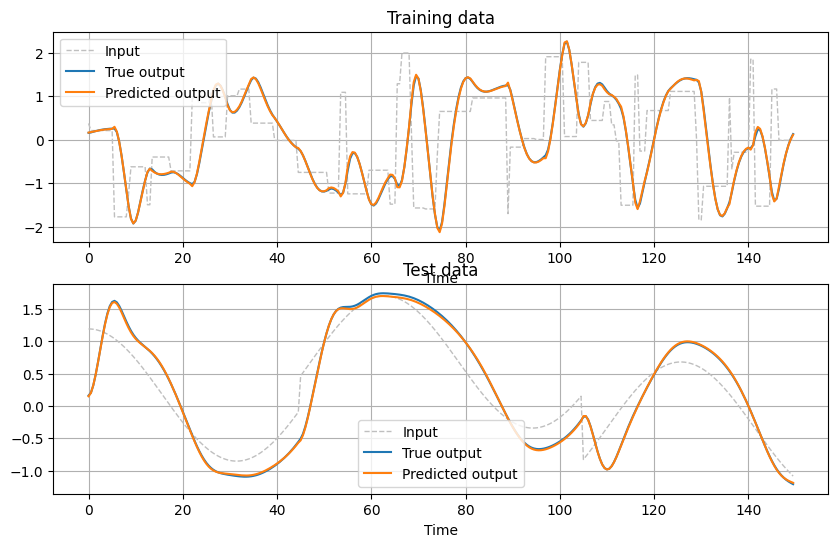

In [ ]:
# # example_continuous_time_nonlinear.py
# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Nonlinear system identification example in continuous time using a recurrent neural network model

#             dx(t)/dt = fx(x(t),u(t),t)
#                 y(t) = fy(x(t),u(t),t)

# (C) 2024 A. Bemporad, December 22, 2024
# """

# from jax_sysid.utils import standard_scale, compute_scores
# from jax_sysid.models import CTModel
# import jax
# import jax.numpy as jnp
# import numpy as np
# import matplotlib.pyplot as plt
# import diffrax

# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations

# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# nx = 2  # number of states
# ny = 1  # number of outputs
# nu = 1  # number of inputs

# # Data generation
# Ts = 0.5  # sample time of control input (time units)
# Tstop = 150 # total excitation time (time units)
# T_train = np.arange(0.,Tstop,Ts)
# #U_train = np.sin(0.002*T_train**2)  # input signal
# u0=4.*np.random.rand()-2.
# U_train = np.empty(T_train.shape).reshape(-1,1)
# for i in range(T_train.size):
#     if np.random.randn()>0.95:
#         u0=4.*np.random.rand()-2.
#     U_train[i] = u0
# x0_train = np.array([0.,0.])  # initial state

# Ts=0.5
# Tstop = 150 # total excitation time (time units)
# T_test = np.arange(0.,Tstop,Ts)
# U_test = (np.cos(0.1*T_test)+.5*(T_test>=Tstop*.3)-1.*(T_test>=Tstop*.7)).reshape(-1,1) # input signal
# x0_test = np.array([0.,0.])  # initial state

# # Continuous time system:
# # yddot = -0.5*ydot + 0.3*u - 0.2*y - 0.1*y**3 --> x1dot = x2
# #                                                  x2dot = -0.5*x2 + 0.3*u - 0.2*x1 - 0.1*x1**3
# def truesystem(x0, U, T):
#     # system generating the training and test dataset    
#     Tc, Uc = diffrax.rectilinear_interpolation(T,U.reshape(-1))
#     input_fcn = diffrax.LinearInterpolation(ts=Tc, ys=Uc)    

#     @jax.jit
#     def state_fcn_true(t, x, args):
#         # state update function xdot = state_fcn(t,x,u)
#         return jnp.array([x[1], -0.5*x[1] + 0.3*input_fcn.evaluate(t) - 0.2*x[0] - 0.1*x[0]**3])

#     @jax.jit
#     def output_fcn_(t, x, args):
#         return x[0]
#     output_fcn_true = jax.jit(jax.vmap(output_fcn_, in_axes=(0,0,None)))

#     @jax.jit
#     def solve(x0):
#         term = diffrax.ODETerm(state_fcn_true)
#         solver = diffrax.Dopri5()
#         t0 = T[0]
#         t1 = T[-1]
#         dt0 = (T[1]-T[0])/10.
#         saveat = diffrax.SaveAt(ts=jnp.array(T))
#         #saveat = SaveAt(ts=jnp.arange(t0,t1,dt0))
#         sol = diffrax.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=x0, args=None, saveat=saveat, max_steps=100000)
#         return sol
    
#     sol = solve(x0)
#     X = sol.ys
#     Y = output_fcn_true(sol.ts, X, None)
#     return Y, X

# Y_train, _ = truesystem(x0_train, U_train, T_train)

# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)

# Y_test, _ = truesystem(x0_test, U_test, T_test)
# Ys_test = (Y_test-ymean)*ygain
# Us_test = (U_test-umean)*ugain

# Ys_train = Ys_train.reshape(-1,1)
# Ys_test = Ys_test.reshape(-1,1)

# # Perform system identification
# def activation(x):
#     return 1. / (1. + jnp.exp(-x))
#     #return jnp.maximum(0., x)

# @jax.jit
# def state_fcn(x, u, t, params):
#     # This computes dx/dt = f(x,u) for continuous-time systems
#     A, B, C, W1, W2, W3, b1, b2 = params
#     return A@x+B@u+W3@activation(W1@x+W2@u+b1)+b2

# @jax.jit
# def output_fcn(x, u, t, params):
#     C = params[2]
#     return C@x

# nnx = 10  # number of hidden neurons in state-update function

# def init_fcn(seed):
#     np.random.seed(seed)
#     A = -np.eye(nx) # start with a stable linear system
#     B = 0.1*np.random.randn(nx, nu)
#     C = 0.1*np.random.randn(ny, nx)
#     W1 = 0.1*np.random.randn(nnx, nx)
#     W2 = 0.5*np.random.randn(nnx, nu)
#     W3 = 0.5*np.random.randn(nx, nnx)
#     b1 = np.zeros(nnx)
#     b2 = np.zeros(nx)
#     return [A, B, C, W1, W2, W3, b1, b2]

# # initialize model coefficients
# model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
# model.integration_options(ode_solver=diffrax.Heun())
# model.init(params=init_fcn(seed=1))
# # L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-4, rho_th=1.e-4, train_x0=True) # default: integral of squared output prediction errors
# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=100, lbfgs_epochs=2000, adam_eta=0.1)

# # Fit model to training data
# # model.fit(Ys_train, Us_train, T_train)

# # Train from different initializations:
# models = model.parallel_fit(Ys_train, Us_train, T_train, init_fcn=init_fcn)
# R2 = model.find_best_model(models, Ys_train, Us_train, T_train)

# x0_train=model.learn_x0(Us_train, Ys_train, T_train)
# Yshat_train, Xhat_train = model.predict(x0_train, Us_train, T_train)

# x0_test=model.learn_x0(Us_test, Ys_test, T_test)
# T_test = np.arange(0.,T_test.size*Ts,Ts)
# Yshat_test, _ = model.predict(x0_test, Us_test, T_test)

# # Compute scores
# R2_train, R2_test, msg = compute_scores(Ys_train, Yshat_train, Ys_test, Yshat_test)
# print(msg)

# # Plot results
# fig, ax = plt.subplots(2, 1, figsize=(10, 6))
# ax[0].plot(T_train, Us_train, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
# ax[0].plot(T_train, Ys_train, label='True output')
# ax[0].plot(T_train, Yshat_train, label='Predicted output')
# ax[0].set_title('Training data')
# ax[0].legend()
# ax[0].grid()
# ax[0].set_xlabel('Time')
# ax[1].plot(T_test, Us_test, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
# ax[1].plot(T_test, Ys_test, label='True output')
# ax[1].plot(T_test, Yshat_test, label='Predicted output')
# ax[1].set_title('Test data')
# ax[1].legend()
# ax[1].grid()
# ax[1].set_xlabel('Time')

# plt.show()


In [ ]:
# # example_custom_loss.py
# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# System identification of linear model with binary outputs.

# (C) 2024 A. Bemporad, march 2, 2024
# """

# import numpy as np
# import jax.numpy as jnp
# import jax
# import matplotlib.pyplot as plt
# from jax_sysid.models import Model
# from jax_sysid.utils import compute_scores

# plotfigs = True  # set to True to plot figures

# # Data generation
# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# # nonlinear system with binary outputs (A. Bemporad, "Training recurrent neural networks by sequential least squares and the alternating direction method of multipliers," Automatica, vol. 156, pp. 111183, October 2023). 
# A = np.array([[.8, .2, -.1], [0, .9, .1], [.1, -.1, .7]])
# B = np.array([[-1.0], [.5], [1.0]])
# C = np.array([[-2.0, 1.5, 0.5]])
# N=2000
# U=np.zeros((N,1))
# Y=np.zeros((N,1))
# nx=3
# ny=1
# nu=1
# qy=0.05
# qx=0.05
# u = np.random.rand()
# x=np.zeros((nx,1))
# for i in range(N):
#     U[i] = u
#     Y[i] = float(C @ (x+x**3/3)  -4. + qy*np.random.randn()>=0)
#     x = A @ x*(0.9+0.1*np.sin(x)) + B * u*(1-u**3) + qx*np.random.randn(nx,1)
#     if np.random.rand() > 0.9:
#         u = np.random.rand()
# Ts=1.0 # sample time

# N_train = 1000  # number of training data
# N_test = N-N_train  # number of test data

# U_train = U[0:N_train]
# Y_train = Y[0:N_train]
# U_test = U[N_train:]
# Y_test = Y[N_train:]

# # Perform system identification
# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations
# @jax.jit
# def state_fcn(x,u,params):
#     W1,W2,W3,b1,b2,W4,W5,b3,b4=params
#     return W3@jnp.tanh(W1@x+W2@u+b1)+b2    
# def sigmoid(x):
#     return 1. / (1. + jnp.exp(-x))  
# @jax.jit
# def output_fcn(x,u,params):
#     W1,W2,W3,b1,b2,W4,W5,b3,b4=params
#     return sigmoid(W5@jnp.tanh(W4@x+b3)+b4)

# model = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# nnx = 5 # number of hidden neurons in state-update function
# nny = 5  # number of hidden neurons in output function

# W1 = 0.1*np.random.randn(nnx,nx)
# W2 = 0.5*np.random.randn(nnx,nu)
# W3 = 0.5*np.random.randn(nx,nnx)
# b1 = np.zeros(nnx)
# b2 = np.zeros(nx)
# W4 = 0.5*np.random.randn(nny,nx)
# W5 = 0.5*np.random.randn(ny,nny)
# b3 = np.zeros(nny)
# b4 = np.zeros(ny)
# model.init(params=[W1,W2,W3,b1,b2,W4,W5,b3,b4]) # initialize model coefficients

# epsil=1.e-4
# @jax.jit
# def cross_entropy_loss(Yhat,Y):
#     loss=jnp.sum(-Y*jnp.log(epsil+Yhat)-(1.-Y)*jnp.log(epsil+1.-Yhat))/Y.shape[0]
#     return loss
# model.loss(rho_x0=0.01, rho_th=0.001, output_loss=cross_entropy_loss) 
# model.optimization(adam_epochs=2000, lbfgs_epochs=2000) # number of epochs for Adam and L-BFGS-B optimization
# model.fit(Y_train, U_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# Yhat_train, _ = model.predict(model.x0, U_train)
# Yhat_train = (Yhat_train>=0.5).astype(float)

# N0 = N_test  # number of data used to learn x0
# x0_test = model.learn_x0(U_test[0:N0], Y_test[0:N0], RTS_epochs=1, LBFGS_refinement=True)  # use RTS Smoother to learn x0
# Yhat_test, _ = model.predict(x0_test, U_test)
# Yhat_test = (Yhat_test>=0.5).astype(float)

# # Compute accuracy scores
# acc_train, acc_test, msg = compute_scores(Y_train, Yhat_train, Y_test, Yhat_test, fit='Accuracy')
# print(msg)

# if plotfigs:
#     T_train = np.arange(N_train)*Ts
#     T_test = np.arange(N_test)*Ts
#     fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#     ax[0].plot(T_train, Y_train, label='measured')
#     ax[0].plot(T_train, Yhat_train, label='jax-sysid')
#     ax[0].legend()
#     ax[0].set_title('Training data')
#     ax[1].plot(T_test, Y_test, label='measured')
#     ax[1].plot(T_test, Yhat_test, label='jax-sysid')
#     ax[1].legend()
#     ax[1].set_title('Test data')
#     plt.show()


Solving NLP with L-BFGS (87 optimization variables) ...
L-BFGS-B done in 1838 iterations.
Elapsed time: 95.44613862037659 s

RTS smoothing, epoch:   1/ 10, MSE loss =  0.003442

RTS smoothing, epoch:   2/ 10, MSE loss =  0.002280

RTS smoothing, epoch:   3/ 10, MSE loss =  0.002236

RTS smoothing, epoch:   4/ 10, MSE loss =  0.002218

RTS smoothing, epoch:   5/ 10, MSE loss =  0.002207

RTS smoothing, epoch:   6/ 10, MSE loss =  0.002199

RTS smoothing, epoch:   7/ 10, MSE loss =  0.002192

RTS smoothing, epoch:   8/ 10, MSE loss =  0.002185

RTS smoothing, epoch:   9/ 10, MSE loss =  0.002180

RTS smoothing, epoch:  10/ 10, MSE loss =  0.002176
R2 score:  training =  99.7900, test =  99.7916


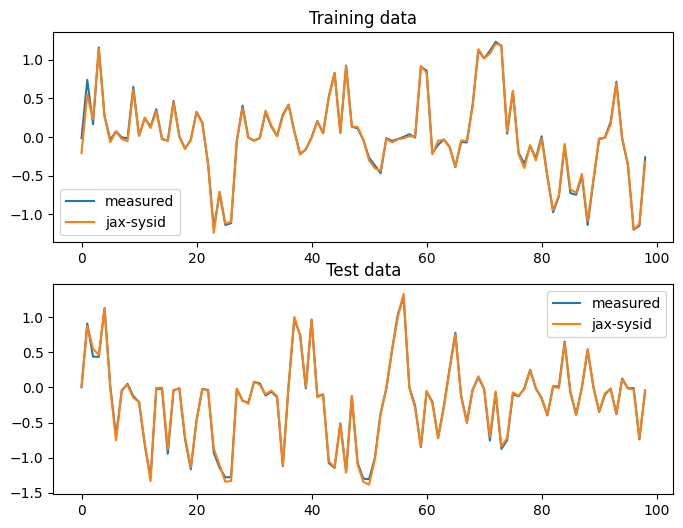

In [ ]:
# # example_custom_nonlinear.py 

# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Nonlinear system identification example using custom residual recurrent neural network model

#             x(k+1) = A*x(k) + B*u(k) + fx(x(k),u(k))
#               y(k) = C*x(k) + fy(x(k),u(k))

# (C) 2024 A. Bemporad, March 6, 2024
# """

# import matplotlib.pyplot as plt
# from jax_sysid.utils import standard_scale, unscale, compute_scores
# from jax_sysid.models import Model
# import jax
# import jax.numpy as jnp
# import numpy as np

# plotfigs = True  # set to True to plot figures

# # Data generation
# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# nx = 3  # number of states
# ny = 1  # number of outputs
# nu = 1  # number of inputs

# N_train = 10000  # number of training data
# N_test = 1000  # number of test data
# Ts = 1.  # sample time

# B = np.random.randn(nx, nu)
# C = np.random.randn(ny, nx)


# def truesystem(x0, U, D, qx, qy):
#     # system generating the training and test dataset
#     N_train = U.shape[0]
#     x = x0.copy()
#     Y = np.empty((N_train, ny))
#     X = np.empty((N_train, nx))
#     for k in range(N_train):
#         X[k] = x
#         Y[k] = np.arctan(C @ x**3) + qy * D[k,nx:]
#         x[0] = .5*np.sin(X[k,0]) + B[0, :]@U[k] * \
#             np.cos(X[k,1]/2.) + qx * D[k,0]
#         x[1] = .6*np.sin(X[k,0]+X[k,2]) + B[1, :]@U[k] * \
#             np.arctan(X[k,0]+X[k,1]) + qx * D[k,1]
#         x[2] = .4*np.exp(-X[k,1]) + B[2, :]@U[k] * \
#             np.sin(-X[k,0]/2.) + qx * D[k,2]
#     return Y, X

# qy = 0.01  # output noise std
# qx = 0.01  # process noise std
# U_train = np.random.rand(N_train, nu)-0.5
# D_train = np.random.randn(N_train, nx+ny)
# x0_train = np.zeros(nx)
# Y_train, _ = truesystem(x0_train, U_train, D_train, qx, qy)

# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)

# U_test = np.random.rand(N_test, nu)-0.5
# D_test = np.random.randn(N_test, nx+ny)
# x0_test = np.zeros(nx)
# Y_test, _ = truesystem(x0_test, U_test, D_test, qx, qy)
# Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
# Us_test = (U_test-umean)*ugain

# # Perform system identification
# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations


# def sigmoid(x):
#     return 1. / (1. + jnp.exp(-x))


# @jax.jit
# def state_fcn(x, u, params):
#     A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
#     return A@x+B@u+W3@sigmoid(W1@x+W2@u+b1)+b2


# @jax.jit
# def output_fcn(x, u, params):
#     A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
#     return C@x+W5@sigmoid(W4@x+b3)+b4


# model = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# nnx = 5  # number of hidden neurons in state-update function
# nny = 5  # number of hidden neurons in output function

# A = 0.5*np.eye(nx)
# B = 0.1*np.random.randn(nx, nu)
# C = 0.1*np.random.randn(ny, nx)
# W1 = 0.1*np.random.randn(nnx, nx)
# W2 = 0.5*np.random.randn(nnx, nu)
# W3 = 0.5*np.random.randn(nx, nnx)
# b1 = np.zeros(nnx)
# b2 = np.zeros(nx)
# W4 = 0.5*np.random.randn(nny, nx)
# W5 = 0.5*np.random.randn(ny, nny)
# b3 = np.zeros(nny)
# b4 = np.zeros(ny)
# # initialize model coefficients
# model.init(params=[A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4])
# # L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-4, rho_th=1.e-4)
# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=0, lbfgs_epochs=2000)
# model.fit(Ys_train, Us_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# # use RTS Smoother to learn x0
# x0_test = model.learn_x0(Us_test, Ys_test, RTS_epochs=10)
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)
# # print(model.sparsity_analysis()) # only useful when tau_th>0

# if plotfigs:
#     T_train = np.arange(N_train)*Ts
#     T_test = np.arange(N_test)*Ts
#     fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#     ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#     ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#     ax[0].legend()
#     ax[0].set_title('Training data')
#     ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#     ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#     ax[1].legend()
#     ax[1].set_title('Test data')
#     plt.show()


  0%|                        |

Solving NLP with Adam (120 optimization variables) ...


100%|████████████████████████|
    f =   0.407964, f* =  0.407945, |grad f| =  1.835548, iter = 1000


Solving NLP with L-BFGS (120 optimization variables) ...
L-BFGS-B done in 903 iterations.
Elapsed time: 18.09246277809143 s

RTS smoothing, epoch:   1/  1, MSE loss =  0.014011

y1: R2 score: training =  99.7505, test =  99.7116
y2: R2 score: training =  99.7508, test =  99.7095
y3: R2 score: training =  99.7548, test =  99.7169
-----
Average R2 score:  training =  99.7520, test =  99.7127
DC gain of true model:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
DC gain of identified model:
 [[ 1.00169384e+00  1.11741586e-03 -7.49100647e-04]
 [-5.29319313e-04  9.88811431e-01  8.20734302e-03]
 [ 3.45142723e-04  2.01874194e-03  9.99032923e-01]]


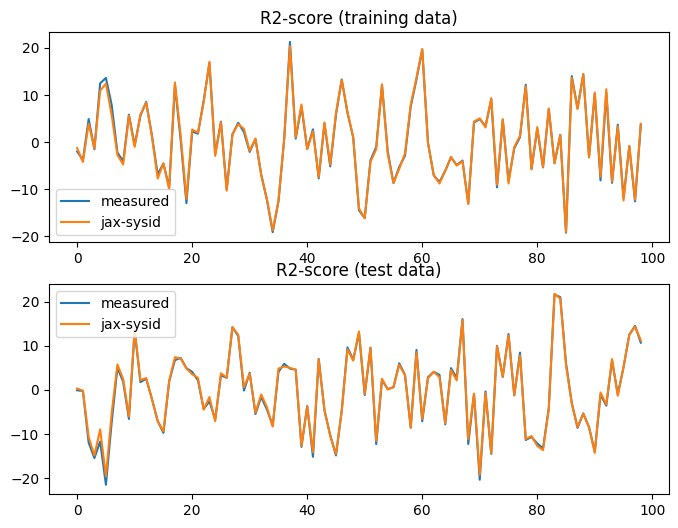

Generating steady-state data ... 
done.


  0%|                        |

Solving NLP with Adam (87 optimization variables) ...


100%|████████████████████████|
    f =   0.139933, f* =  0.139933, |grad f| =  0.156078, iter = 1000


Solving NLP with L-BFGS (87 optimization variables) ...
L-BFGS-B done in 638 iterations.
Elapsed time: 137.8138873577118 s

RTS smoothing, epoch:   1/ 10, MSE loss =  0.004467

RTS smoothing, epoch:   2/ 10, MSE loss =  0.003701

RTS smoothing, epoch:   3/ 10, MSE loss =  0.003636

RTS smoothing, epoch:   4/ 10, MSE loss =  0.003602

RTS smoothing, epoch:   5/ 10, MSE loss =  0.003584

RTS smoothing, epoch:   6/ 10, MSE loss =  0.003573

RTS smoothing, epoch:   7/ 10, MSE loss =  0.003566

RTS smoothing, epoch:   8/ 10, MSE loss =  0.003560

RTS smoothing, epoch:   9/ 10, MSE loss =  0.003556

RTS smoothing, epoch:  10/ 10, MSE loss =  0.003553
R2 score:  training =  99.8066, test =  99.5784


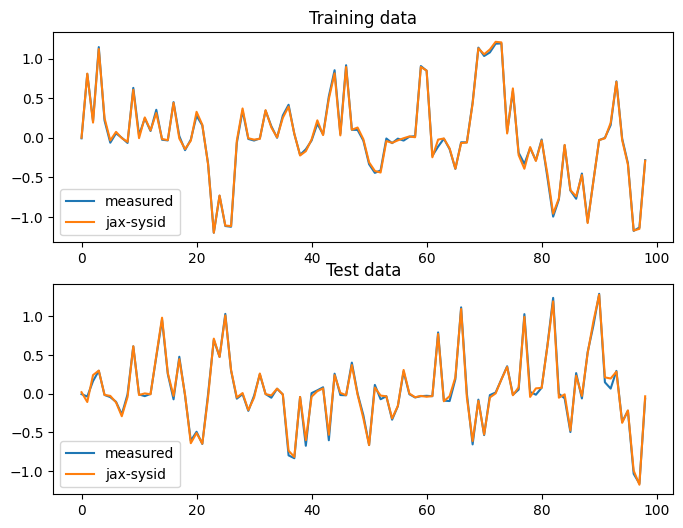

Generating steady-states on test inputs:


  2%|▏         | 2/100 [00:00<00:15,  6.27it/s]

..

  4%|▍         | 4/100 [00:00<00:12,  7.73it/s]

..

  6%|▌         | 6/100 [00:00<00:11,  7.93it/s]

..

  8%|▊         | 8/100 [00:01<00:11,  8.10it/s]

..

 10%|█         | 10/100 [00:01<00:11,  8.15it/s]

..

 12%|█▏        | 12/100 [00:01<00:10,  8.11it/s]

..

 14%|█▍        | 14/100 [00:01<00:10,  7.91it/s]

..

 16%|█▌        | 16/100 [00:02<00:10,  8.00it/s]

..

 18%|█▊        | 18/100 [00:02<00:10,  8.08it/s]

..

 20%|██        | 20/100 [00:02<00:09,  8.07it/s]

..

 22%|██▏       | 22/100 [00:02<00:09,  8.04it/s]

..

 24%|██▍       | 24/100 [00:03<00:09,  8.01it/s]

..

 26%|██▌       | 26/100 [00:03<00:09,  7.89it/s]

..

 28%|██▊       | 28/100 [00:03<00:08,  8.20it/s]

..

 30%|███       | 30/100 [00:03<00:08,  8.40it/s]

..

 32%|███▏      | 32/100 [00:04<00:07,  8.57it/s]

..

 34%|███▍      | 34/100 [00:04<00:07,  8.75it/s]

..

 36%|███▌      | 36/100 [00:04<00:07,  8.69it/s]

..

 38%|███▊      | 38/100 [00:04<00:07,  8.66it/s]

..

 40%|████      | 40/100 [00:04<00:06,  8.67it/s]

..

 42%|████▏     | 42/100 [00:05<00:06,  8.71it/s]

..

 44%|████▍     | 44/100 [00:05<00:06,  8.83it/s]

..

 47%|████▋     | 47/100 [00:05<00:05,  8.89it/s]

...

 49%|████▉     | 49/100 [00:05<00:06,  8.46it/s]

..

 52%|█████▏    | 52/100 [00:06<00:05,  8.63it/s]

...

 54%|█████▍    | 54/100 [00:06<00:05,  8.50it/s]

..

 56%|█████▌    | 56/100 [00:06<00:05,  8.10it/s]

..

 58%|█████▊    | 58/100 [00:07<00:05,  8.30it/s]

..

 60%|██████    | 60/100 [00:07<00:04,  8.61it/s]

..

 62%|██████▏   | 62/100 [00:07<00:04,  8.44it/s]

..

 64%|██████▍   | 64/100 [00:07<00:04,  8.51it/s]

..

 66%|██████▌   | 66/100 [00:07<00:04,  8.44it/s]

..

 68%|██████▊   | 68/100 [00:08<00:03,  8.57it/s]

..

 70%|███████   | 70/100 [00:08<00:03,  8.59it/s]

..

 72%|███████▏  | 72/100 [00:08<00:03,  8.80it/s]

..

 75%|███████▌  | 75/100 [00:09<00:02,  8.90it/s]

...

 77%|███████▋  | 77/100 [00:09<00:02,  8.85it/s]

..

 79%|███████▉  | 79/100 [00:09<00:02,  8.91it/s]

..

 81%|████████  | 81/100 [00:09<00:02,  8.75it/s]

..

 83%|████████▎ | 83/100 [00:09<00:01,  8.52it/s]

..

 85%|████████▌ | 85/100 [00:10<00:01,  8.46it/s]

..

 87%|████████▋ | 87/100 [00:10<00:01,  8.39it/s]

..

 89%|████████▉ | 89/100 [00:10<00:01,  8.35it/s]

..

 91%|█████████ | 91/100 [00:10<00:01,  8.34it/s]

..

 93%|█████████▎| 93/100 [00:11<00:00,  8.27it/s]

..

 95%|█████████▌| 95/100 [00:11<00:00,  8.15it/s]

..

 97%|█████████▋| 97/100 [00:11<00:00,  8.26it/s]

..

 99%|█████████▉| 99/100 [00:11<00:00,  7.93it/s]

..

100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


.done.


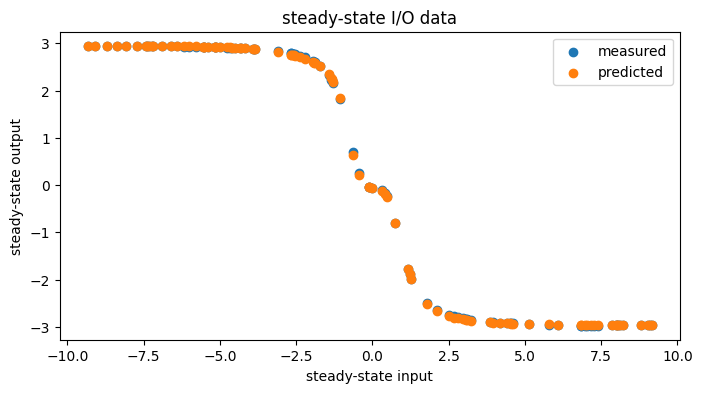

In [ ]:
# # example_dcgain.py

# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Linear and nonlinear system identification examples with additional emphasis on the DC gain of the system.
# Steady-state data are used to fit the DC gain of the system. In the special case of linear systems, the DC gain can be fit instead to a given matrix gain.

# (C) 2024 A. Bemporad, October 10, 2024
# """

# import matplotlib.pyplot as plt
# from jax_sysid.utils import standard_scale, unscale, compute_scores
# from jax_sysid.models import Model, LinearModel
# import jax
# import jax.numpy as jnp
# import numpy as np
# from tqdm import tqdm

# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:    
#     jax.config.update("jax_enable_x64", True) # Enable 64-bit computations

# runLTImodel =True
# runNLmodel = True

# plotfigs = True  # set to True to plot figures

# # Data generation
# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# if runLTImodel:
#     nx = 8  # number of states
#     ny = 3  # number of outputs
#     nu = 3  # number of inputs

#     N_train = 1000  # number of training data
#     N_test = 1000  # number of test data
#     Ts = 1.  # sample time

#     # True linear dynamics
#     At = np.random.randn(nx, nx)
#     # makes matrix strictly Schur
#     At = At/np.max(np.abs(np.linalg.eig(At)[0]))*0.95
#     Bt = np.random.randn(nx, nu)
#     Ct = np.random.randn(ny, nx)
#     Dt = np.zeros((ny, nu))  # no direct feedthrough

#     DCgain_t=Ct@np.linalg.inv(np.eye(nx)-At)@Bt+Dt # true DC gain
#     Ct = np.linalg.inv(DCgain_t)@Ct # scale C matrix to have unit DCgain_t
#     DCgain_t = np.eye(ny)

#     qy = 0.02  # output noise std
#     qx = 0.02  # process noise std

#     U_train = np.random.rand(N_train, nu)-0.5
#     x0_train = np.random.randn(nx)
#     # Create true model to generate the training dataset
#     truemodel = LinearModel(nx, ny, nu, feedthrough=False)
#     # truemodel.ss(feedthrough=False) # make model a linear state-space model without direct feedthrough
#     truemodel.init(params=[At, Bt, Ct], x0=x0_train)
#     Y_train, X_train = truemodel.predict(x0_train, U_train, qx, qy)
#     Ys_train, ymean, ygain = standard_scale(Y_train)
#     Us_train, umean, ugain = standard_scale(U_train)

#     U_test = np.random.rand(N_test, nu)-0.5
#     x0_test = np.random.randn(nx)
#     Y_test, X_test = truemodel.predict(x0_test, U_test, qx, qy)
#     Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
#     Us_test = (U_test-umean)*ugain

#     model = LinearModel(nx, ny, nu, feedthrough=False)  # create linear model

#     use_ss_data = True
    
#     if use_ss_data:        
#         # generate steady-state training data
#         N_ss = 100
#         Uss = 5*(np.random.rand(N_ss,nu)-.5) # steady-state input values
#         Yss = np.array([DCgain_t@Uss[k] for k in range(N_ss)]) # steady-state output values
#         Uss = (Uss-umean)*ugain
#         Yss = (Yss-ymean)*ygain

#         # Define loss to penalize deviations between predicted and measured steady-state values
#         dcgain_loss = model.dcgain_loss(Uss, Yss, beta=1.)
#     else:
#         # scaled DC gain: Yss = DCgain_t*Uss
#         #                 (Yss_scaled/ygain)+ymean = DCgain_t * (Uss_scaled/ugain+umean)#               #                  --> DCgain_scaled = ygain*DCgain_t/ugain
#         DCgain = (DCgain_t.T*ygain).T/ugain
#         dcgain_loss = model.dcgain_loss(DCgain = DCgain, beta=1.)

#     # Define total loss = L2-regularization on initial state and model coefficients + DC-gain loss
#     model.loss(rho_x0=1.e-3, rho_th=1.e-2, custom_regularization = dcgain_loss)

#     # number of epochs for Adam and L-BFGS-B optimization
#     model.optimization(adam_epochs=1000, lbfgs_epochs=1000)
#     model.fit(Ys_train, Us_train)
#     t0 = model.t_solve

#     print(f"Elapsed time: {t0} s")
#     Yshat_train, _ = model.predict(model.x0, Us_train)
#     Yhat_train = unscale(Yshat_train, ymean, ygain)

#     x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
#     Yshat_test, _ = model.predict(x0_test, Us_test)
#     Yhat_test = unscale(Yshat_test, ymean, ygain)
#     R2, R2_test, msg = compute_scores(
#         Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

#     print(msg)

#     # Print eigenvalues of identified A matrix
#     A, B, C, D = model.ssdata()
#     DCgain_scaled=C@np.linalg.inv(np.eye(nx)-A)@B+D # DC gain of identified model on scaled data
#     # scaled DC gain: (Yss-ymean)*ygain = DCgain_scaled*(Uss-umean)*ugain
#     #                 --> DCgain = (DCgain_scaled*ugain)/ygain
#     DCgain = (DCgain_scaled.T/ygain).T*ugain
    
#     print(f"DC gain of true model:\n {DCgain_t}")
#     print(f"DC gain of identified model:\n {DCgain}")
    
#     if plotfigs:
#         T_train = np.arange(N_train)*Ts
#         T_test = np.arange(N_test)*Ts
#         fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#         ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#         ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#         ax[0].legend()
#         ax[0].set_title('R2-score (training data)')
#         ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#         ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#         ax[1].legend()
#         ax[1].set_title('R2-score (test data)')
#         plt.show()

# if runNLmodel:
#     np.random.seed(seed)
    
#     nx = 3  # number of states
#     ny = 1  # number of outputs
#     nu = 1  # number of inputs

#     N_train = 100  # number of training data
#     N_test = 1000  # number of test data
#     Ts = 1.  # sample time

#     B = np.random.randn(nx, nu)
#     C = np.random.randn(ny, nx)

#     @jax.jit
#     def truesystem(x0, U, D, qx, qy):    
#         # system generating the training and test dataset (fast jax.lax.scan version)
#         @jax.jit
#         def true_dynamics(x, ud):
#             u = ud[:nu]
#             d = ud[nu:]
#             xnext = jnp.array([.5*jnp.sin(x[0]) + B[0, :]@u * jnp.cos(x[1]/2.) + qx * d[0],
#                     .6*jnp.sin(x[0]+x[2]) + B[1, :]@u * jnp.arctan(x[0]+x[1]) + qx * d[1],
#                     .4*jnp.exp(-x[1]) + B[2, :]@u * jnp.sin(-x[0]/2.) + qx * d[2]])
#             y = jnp.arctan(C @ x**3) + qy * d[3:]
#             return xnext, y
#         _, Y = jax.lax.scan(true_dynamics, jnp.array(x0), jnp.hstack((U,D)))
#         return Y

#     # Generate transient data
#     qy = 0.01  # output noise std
#     qx = 0.01  # process noise std
#     U_train = np.random.rand(N_train, nu)-0.5
#     D_train = np.random.randn(N_train, nx+ny)
#     x0_train = np.zeros(nx)
#     Y_train = truesystem(x0_train, U_train, D_train, qx, qy)

#     U_test = np.random.rand(N_test, nu)-0.5
#     D_test = np.random.randn(N_test, nx+ny)
#     x0_test = np.zeros(nx)
#     Y_test = truesystem(x0_test, U_test, D_test, qx, qy)

#     # generate steady-state training and test data
#     N_train_ss = 100
#     N_test_ss = 100
#     N = N_train_ss + N_test_ss
#     Uss = 5*(np.random.rand(N)-.5) # steady-state input values
#     M = 100 # number of data for each transient experiment
#     D = 0.*np.random.randn(M,nx+ny)

#     # simulate system for each steady-state input value and get average of last L samples
#     print("Generating steady-state data ... ")
#     L=10
#     Yss = np.array([np.mean(truesystem(np.zeros(nx),Uss[k]*np.ones((M,1)),D,0.01,0.01)[-L:], axis=0).item() for k in range(N)])
#     print("done.")

#     # scale data
#     Ys_train, ymean, ygain = standard_scale(Y_train)
#     Us_train, umean, ugain = standard_scale(U_train)
#     Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
#     Us_test = (U_test-umean)*ugain
#     Uss = (Uss-umean)*ugain
#     Yss = (Yss-ymean)*ygain

#     # Define nonlinear model
#     def sigmoid(x):
#         return 1. / (1. + jnp.exp(-x))

#     @jax.jit
#     def state_fcn(x, u, params):
#         A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
#         return A@x+B@u+W3@sigmoid(W1@x+W2@u+b1)+b2

#     @jax.jit
#     def output_fcn(x, u, params):
#         A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
#         return C@x+W5@sigmoid(W4@x+b3)+b4

#     model = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

#     nnx = 5  # number of hidden neurons in state-update function
#     nny = 5  # number of hidden neurons in output function

#     A = 0.5*np.eye(nx)
#     B = 0.1*np.random.randn(nx, nu)
#     C = 0.1*np.random.randn(ny, nx)
#     W1 = 0.1*np.random.randn(nnx, nx)
#     W2 = 0.5*np.random.randn(nnx, nu)
#     W3 = 0.5*np.random.randn(nx, nnx)
#     b1 = np.zeros(nnx)
#     b2 = np.zeros(nx)
#     W4 = 0.5*np.random.randn(nny, nx)
#     W5 = 0.5*np.random.randn(ny, nny)
#     b3 = np.zeros(nny)
#     b4 = np.zeros(ny)
#     # initialize model coefficients
#     model.init(params=[A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4])

#     # Define loss to penalize deviations between predicted and measured steady-state values
#     dcgain_loss = model.dcgain_loss(Uss[:N_train_ss], Yss[:N_train_ss], beta=1.)
    
#     # Define total loss = L2-regularization on initial state and model coefficients + DC-gain loss
#     model.loss(rho_x0=1.e-4, rho_th=1.e-4, custom_regularization = dcgain_loss)
    
#     # number of epochs for Adam and L-BFGS-B optimization
#     model.optimization(adam_epochs=1000, lbfgs_epochs=2000)

#     model.fit(Ys_train, Us_train)
#     t0 = model.t_solve

#     print(f"Elapsed time: {t0} s")
#     Yshat_train, _ = model.predict(model.x0, Us_train)
#     Yhat_train = unscale(Yshat_train, ymean, ygain)

#     # use RTS Smoother to learn x0
#     x0_test = model.learn_x0(Us_test, Ys_test, RTS_epochs=10)
#     Yshat_test, _ = model.predict(x0_test, Us_test)
#     Yhat_test = unscale(Yshat_test, ymean, ygain)
#     R2, R2_test, msg = compute_scores(
#         Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

#     print(msg)
#     # print(model.sparsity_analysis()) # only useful when tau_th>0

#     if plotfigs:
#         T_train = np.arange(N_train)*Ts
#         T_test = np.arange(N_test)*Ts
#         fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#         ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#         ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#         ax[0].legend()
#         ax[0].set_title('Training data')
#         ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#         ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#         ax[1].legend()
#         ax[1].set_title('Test data')
#         plt.show()

#     # Simulate model for each steady-state input value and get average of last L samples
#     print("Generating steady-states on test inputs:")
#     Yss_test = np.empty((N_test_ss,ny))
#     for k in tqdm(range(N_test_ss)):
#         y,_ = model.predict(np.zeros(nx),Uss[N_train_ss+k]*np.ones((M,1)))
#         Yss_test[k,:] = y[-1]
#         print(".", end="")
#     print("done.")

#     if plotfigs:
#         plt.figure(figsize=(8,4))
#         plt.scatter(Uss[N_train_ss:],Yss[N_train_ss:], label="measured")
#         plt.scatter(Uss[N_train_ss:],Yss_test, label="predicted")
#         plt.legend()
#         plt.xlabel('steady-state input')
#         plt.ylabel('steady-state output')
#         plt.title('steady-state I/O data')


In [ ]:
# # example_linear_force_stability.py
# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Linear system identification example with stability enforcement.

# (C) 2024 A. Bemporad, June 11, 2024
#     Revised by A. Bemporad, September 27-30, 2025
# """

# import matplotlib.pyplot as plt
# from jax_sysid.utils import compute_scores, print_eigs
# from jax_sysid.models import LinearModel
# import numpy as np

# plotfigs = True  # set to True to plot figures

# # Data generation
# seed = 2  # for reproducibility of results
# np.random.seed(seed)

# nx = 3  # number of states
# ny = 1  # number of outputs
# nu = 1  # number of inputs

# N_train = 1000  # number of training data
# N_test = 1000  # number of test data
# Ts = 1.  # sample time

# # True linear dynamics
# At = np.array([[1.0001, 0.5, 0.5], [0., 0.9, -.2], [0., 0., 0.7]])
# #At = np.array([[1.0001-.1, 0.5, 0.5], [0., 0.9, -.2], [0., 0., 0.7]]) # As. stable, but ||A||_2>1
# Bt = np.round(np.random.randn(nx, nu)*10000.)/10000.
# Ct = np.round(np.random.randn(ny, nx)*10000.)/10000.
# Dt = np.zeros((ny, nu))  # no direct feedthrough

# qy = 0.05  # output noise std
# qx = 0.01  # process noise std


# U_train = np.random.rand(N_train, nu)-0.5
# x0_train = np.random.randn(nx)
# # Create true model to generate the training dataset
# truemodel = LinearModel(nx, ny, nu, feedthrough=False)
# # truemodel.ss(feedthrough=False) # make model a linear state-space model without direct feedthrough
# truemodel.init(params=[At, Bt, Ct], x0=x0_train)

# Y_train, X_train = truemodel.predict(x0_train, U_train, qx, qy)
# yscale=np.max(np.abs(Y_train))
# Ys_train=Y_train/yscale

# U_test = np.random.rand(N_test, nu)-0.5
# x0_test = np.random.randn(nx)
# Y_test, X_test = truemodel.predict(x0_test, U_test, qx, qy)

# model = LinearModel(nx, ny, nu, feedthrough=False, sigma=0.5, stability=True)  # create linear model with stability enforcement

# # # Alternative: enforce stability of the identified linear model via penalty function
# # model = LinearModel(nx, ny, nu, feedthrough=False, sigma=0.5)  # create linear model with 
# # model.force_stability(rho_A=1.e3, epsilon_A=1.e-3)
    
# model.loss(rho_x0=1.e-3, rho_th=1.e-2)

# # MSE loss + L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-4, rho_th=1.e-4, xsat=1.e4)
# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=3000, lbfgs_epochs=5000)
# model.fit(Ys_train, U_train)
# t0 = model.t_solve
# model.params[1]=model.params[1]*yscale

# print(f"Elapsed time: {t0} s")

# x0_train = model.learn_x0(U_train, Y_train, LBFGS_refinement=True)  # use RTS Smoother to learn x0

# Yhat_train, _ = model.predict(x0_train, U_train)

# x0_test = model.learn_x0(U_test, Y_test, LBFGS_refinement=True)  # use RTS Smoother to learn x0
# Yhat_test, _ = model.predict(x0_test, U_test)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)

# # Print eigenvalues of identified A matrix
# A, B, C, D = model.ssdata()
# print_eigs(A, num_digits=8)

# if plotfigs:
#     T_train = np.arange(N_train)*Ts
#     T_test = np.arange(N_test)*Ts
#     fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#     ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#     ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#     ax[0].legend()
#     ax[0].set_title('Training data')
#     ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#     ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#     ax[1].legend()
#     ax[1].set_title('Test data')
#     plt.show()


In [ ]:
# # example_linear_positive.py
# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# System identification of a positive linear system.

# (C) 2024 A. Bemporad, May 4, 2024
# """

# import matplotlib.pyplot as plt
# from jax_sysid.utils import compute_scores
# from jax_sysid.models import LinearModel
# import numpy as np

# plotfigs = True  # set to True to plot figures

# # Data generation
# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# nx = 4  # number of states
# ny = 1  # number of outputs
# nu = 1  # number of inputs

# N_train = 1000  # number of training data
# N_test = 1000  # number of test data
# Ts = 1.  # sample time

# # True linear dynamics (which is not a positive linear system)
# At = np.random.rand(nx, nx); At[0,0] = -0.1; At[3,2] = -0.3; At[2,1] = -0.5
# # makes matrix strictly Schur
# At = At/np.max(np.abs(np.linalg.eig(At)[0]))*0.95
# Bt = np.random.rand(nx, nu); Bt[0,0] = -0.1
# Ct = np.random.rand(ny, nx); Ct[0,0] = -0.1
# Dt = np.zeros((ny, nu))  # no direct feedthrough

# qy = 0.1  # measurement noise std
# qx = 0.0  # process noise std

# U_train = np.random.randn(N_train, nu) # input excitation
# x0_train = np.random.rand(nx) # nonegative initial state
# # Create true model to generate the training dataset
# truemodel = LinearModel(nx, ny, nu, feedthrough=False)
# # truemodel.ss(feedthrough=False) # make model a linear state-space model without direct feedthrough
# truemodel.init(params=[At, Bt, Ct], x0=x0_train)
# Y_train, X_train = truemodel.predict(x0_train, U_train, qx, qy)
# ymax = np.max(np.abs(Y_train))
# umax = np.max(np.abs(U_train))
# Ys_train = Y_train/ymax # scale outputs
# Us_train = U_train/umax # scale inputs

# U_test = np.random.randn(N_test, nu)
# x0_test = np.random.rand(nx)
# Y_test, X_test = truemodel.predict(x0_test, U_test, qx, qy)
# Ys_test = Y_test/ymax # use same scaling as for training data
# Us_test = U_test/umax

# # Perform system identification
# model = LinearModel(nx, ny, nu, feedthrough=False)  # create linear model
# # MSE loss + L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-3, rho_th=1.e-2)

# # define lower bounds for the model coefficients to make them all nonnegative
# params_min = [np.zeros_like(thi) for thi in model.params]

# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=0, lbfgs_epochs=1000, params_min=params_min, x0_min=np.zeros(nx))
# model.fit(Ys_train, Us_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")

# A,B,C = model.params
# print(f"Matrix A:\n\n {A}\n")
# print(f"Matrix B:\n\n {B}\n")
# print(f"Matrix C:\n\n {C}\n")
# print(f"Initial state x0:\n\n {model.x0}\n")

# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = Yshat_train*ymax  # unscale outputs

# x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = Yshat_test*ymax  # unscale outputs
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)

# if plotfigs:
#     T_train = np.arange(N_train)*Ts
#     T_test = np.arange(N_test)*Ts
#     fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#     ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#     ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#     ax[0].legend()
#     ax[0].grid()
#     ax[0].set_title('Training data')
#     ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#     ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#     ax[1].legend()
#     ax[1].grid()
#     ax[1].set_title('Test data')
#     plt.show()



In [ ]:
# # example_linear.py

# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Linear system identification example.

# (C) 2024 A. Bemporad, February 25, 2024
# """

# import matplotlib.pyplot as plt
# from jax_sysid.utils import standard_scale, unscale, compute_scores, print_eigs
# from jax_sysid.models import LinearModel
# import numpy as np

# plotfigs = False  # set to True to plot figures

# # Data generation
# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# nx = 8  # number of states
# ny = 3  # number of outputs
# nu = 3  # number of inputs

# N_train = 5000  # number of training data
# N_test = 1000  # number of test data
# Ts = 1.  # sample time

# # True linear dynamics
# At = np.random.randn(nx, nx)
# # makes matrix strictly Schur
# At = At/np.max(np.abs(np.linalg.eig(At)[0]))*0.95
# Bt = np.random.randn(nx, nu)
# Ct = np.random.randn(ny, nx)
# Dt = np.zeros((ny, nu))  # no direct feedthrough

# qy = 0.02  # output noise std
# qx = 0.02  # process noise std

# U_train = np.random.rand(N_train, nu)-0.5
# x0_train = np.random.randn(nx)
# # Create true model to generate the training dataset
# truemodel = LinearModel(nx, ny, nu, feedthrough=False)
# # truemodel.ss(feedthrough=False) # make model a linear state-space model without direct feedthrough
# truemodel.init(params=[At, Bt, Ct], x0=x0_train)
# Y_train, X_train = truemodel.predict(x0_train, U_train, qx, qy)
# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)

# U_test = np.random.rand(N_test, nu)-0.5
# x0_test = np.random.randn(nx)
# Y_test, X_test = truemodel.predict(x0_test, U_test, qx, qy)
# Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
# Us_test = (U_test-umean)*ugain

# # Perform system identification
# model = LinearModel(nx, ny, nu, feedthrough=False)  # create linear model
# # MSE loss + L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-3, rho_th=1.e-2)
# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=0, lbfgs_epochs=1000)
# model.fit(Ys_train, Us_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)

# # Print eigenvalues of identified A matrix
# A, B, C, D = model.ssdata()
# print_eigs(A)

# if plotfigs:
#     T_train = np.arange(N_train)*Ts
#     T_test = np.arange(N_test)*Ts
#     fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#     ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#     ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#     ax[0].legend()
#     ax[0].set_title('Training data')
#     ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#     ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#     ax[1].legend()
#     ax[1].set_title('Test data')
#     plt.show()

# ########################################################################################
# # Now add L1-regularization with penalty tau_th on the model coefficients
# model.loss(rho_x0=1.e-3, rho_th=1.e-2, tau_th=0.03)
# model.init()  # reinitialize model coefficients
# model.fit(Ys_train, Us_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)
# print(model.sparsity_analysis())

# ########################################################################################
# # Use group-Lasso regularization with penalty tau_g to reduce model order
# model.loss(rho_x0=1.e-3, rho_th=1.e-2, tau_g=0.1)
# model.group_lasso_x()  # introduce group-Lasso penalty to reduce the number of states
# model.init()  # reinitialize model coefficients
# model.fit(Ys_train, Us_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)
# print(model.sparsity_analysis())

# ########################################################################################
# # Use group-Lasso regularization with penalty tau_g to reduce number of inputs
# Bt[:, 2] = Bt[:, 2]/1000.  # make input #3 almost irrelevant
# truemodel.init(params=[At, Bt, Ct], x0=x0_train)
# Y_train, X_train = truemodel.predict(x0_train, U_train, qx, qy)
# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)

# U_test = np.random.rand(N_test, nu)-0.5
# x0_test = np.random.randn(nx)
# Y_test, X_test = truemodel.predict(x0_test, U_test, qx, qy)
# Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
# Us_test = (U_test-umean)*ugain

# model.loss(rho_x0=1.e-3, rho_th=1.e-2, tau_g=0.15)
# model.group_lasso_u()  # introduce group-Lasso penalty to reduce the number of inputs
# model.init()  # reinitialize model coefficients
# model.fit(Ys_train, Us_train)
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)
# print(model.sparsity_analysis())

# ########################################################################################
# # Multiple experiments
# model.loss(rho_x0=1.e-3, rho_th=1.e-2, tau_th=0.03)
# model.init()  # reinitialize model coefficients
# model.fit([Ys_train[0:int(N_train/3)], Ys_train[int(N_train/3):int(2*N_train/3)], Ys_train[int(2*N_train/3):]],
#           [Us_train[0:int(N_train/3)], Us_train[int(N_train/3):int(2*N_train/3)], Us_train[int(2*N_train/3):]])
# t0 = model.t_solve

# print(f"Elapsed time: {t0} s")
# # simulate the entire experiment
# Yshat_train, _ = model.predict(model.x0[0], Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# x0_test = model.learn_x0(Us_test, Ys_test)  # use RTS Smoother to learn x0
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)
# print(model.sparsity_analysis())


In [ ]:
# # example_qlpv.py
# """
# Quasi-LPV identification example.

# (C) 2024 A. Bemporad, August 13, 2024
# """

# from jax_sysid.utils import unscale, compute_scores, standard_scale
# from jax_sysid.models import qLPVModel, find_best_model
# import numpy as np
# import jax
# import flax.linen as nn
# import matplotlib.pyplot as plt
# import time

# plotfigs = True  # set to True to plot figures

# t0 = time.time()

# # Data generation
# seed = 0  # for reproducibility of results
# np.random.seed(seed)

# nx = 3  # number of states
# ny = 1  # number of outputs
# nu = 1  # number of inputs
# # number of scheduling parameters (npar>=0. If npar=0, the model is linear time-invariant)
# npar = 2
# nn1, nn2 = 6, 6  # number of neurons in FNN defining the scheduling vector

# N_train = 5000  # number of training data
# N_test = 1000  # number of test data
# Ts = 1.  # sample time

# B = np.floor(np.random.randn(nx, nu)*10.)/10.
# C = np.floor(np.random.randn(ny, nx)*10.)/10.

# def truesystem(x0, U, D, qx, qy):
#     # system generating the training and test dataset
#     N_train = U.shape[0]
#     x = x0.copy()
#     Y = np.empty((N_train, ny))
#     X = np.empty((N_train, nx))
#     for k in range(N_train):
#         X[k] = x
#         Y[k] = np.arctan(C @ x**3) + qy * D[k,nx:]
#         x[0] = .5*np.sin(X[k,0]) + B[0, :]@U[k] * \
#             np.cos(X[k,1]/2.) + qx * D[k,0]
#         x[1] = .6*np.sin(X[k,0]+X[k,2]) + B[1, :]@U[k] * \
#             np.arctan(X[k,0]+X[k,1]) + qx * D[k,1]
#         x[2] = .4*np.exp(-X[k,1]) + B[2, :]@U[k] * \
#             np.sin(-X[k,0]/2.) + qx * D[k,2]
#     return Y, X

# qy = 0.01  # output noise std
# qx = 0.01  # process noise std
# U_train = np.random.rand(N_train, nu)-0.5
# D_train = np.random.randn(N_train, nx+ny)
# x0_train = np.zeros(nx)
# Y_train, _ = truesystem(x0_train, U_train, D_train, qx, qy)

# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)

# U_test = np.random.rand(N_test, nu)-0.5
# D_test = np.random.randn(N_train, nx+ny)
# x0_test = np.zeros(nx)
# Y_test, _ = truesystem(x0_test, U_test, D_test, qx, qy)
# Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
# Us_test = (U_test-umean)*ugain

# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)

# rho_th = 1.e-4  # L2-regularization parameter for model coefficients
# rho_x0 = 1.e-4  # L2-regularization parameter for initial state
# adam_epochs = 1000
# lbfgs_epochs = 5000
# memory = 20  # memory parameter for L-BFGS-B optimization
# iprint = 50  # -1  # verbosity level for L-BFGS-B optimization
# train_x0 = True

# # Initialize parameters of scheduling function (feedforward neural network)
# W1x = np.random.randn(nn1, nx)
# W1u = np.random.randn(nn1, nu)
# b1 = np.zeros(nn1)
# W2 = np.random.randn(nn2, nn1)
# b2 = np.zeros(nn2)
# W3 = np.random.randn(npar, nn2)
# b3 = np.zeros(npar)

# qlpv_params_init = [W1x, W1u, b1, W2, b2, W3, b3]

# # Scheduling function
# @jax.jit
# def qlpv_fcn(x, u, qlpv_params):
#     W1x, W1u, b1, W2, b2, W3, b3 = qlpv_params
#     p = nn.sigmoid(
#         W3 @ nn.swish(W2 @ nn.swish(W1x @ x + W1u @ u + b1) + b2) + b3)
#     return p

# # Define qLPV model
# model = qLPVModel(nx, ny, nu, npar, qlpv_fcn, qlpv_params_init,
#                 feedthrough=False, y_in_x=False, x0=None, sigma=0.5, seed=0, Ts=None)
# model.loss(rho_th=rho_th, rho_x0=rho_x0)
# model.optimization(adam_epochs=adam_epochs,
#                 lbfgs_epochs=lbfgs_epochs, memory=memory, iprint=iprint)
# model.fit(Ys_train, Us_train, LTI_training=True)

# # Extract matrices defining qLPV structure
# Alin, Blin, Clin, Dlin, Ap, Bp, Cp, Dp = model.ssdata()
# # Extract parameters defining the scheduling function
# qlpv_params = model.params[:model.nqlpv_params]

# # Compute BFR scores
# Yshat_train, X_train = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, 
# ymean, ygain)
# x0_test = model.learn_x0(
#     Us_test, Ys_test, LBFGS_refinement=True, LBFGS_rho_x0=rho_x0, verbosity=0)
# Yshat_test, X_test = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)

# BFR_train, BFR_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='BFR')

# if plotfigs:
#     plt.figure(figsize=(8, 4))
#     plt.plot(Y_test, label='True')
#     plt.plot(Yhat_test, label='Predicted')
#     plt.xlabel('Time')
#     plt.ylabel('output (test data)')
#     plt.legend()
#     plt.show()

#     p_test = np.array([qlpv_fcn(x, u, qlpv_params)
#                     for x, u in zip(X_test, Us_test)])

#     plt.figure(figsize=(8, 4))
#     plt.plot(p_test)
#     plt.grid()
#     plt.title('scheduling vector')

# # Repeat with group-Lasso regularization to possibly reduce the number of scheduling variables
# model_group = qLPVModel(nx, ny, nu, npar, qlpv_fcn, qlpv_params_init,
#                 feedthrough=False, y_in_x=False, x0=None, sigma=0.5, seed=0, Ts=None)
# model_group.loss(rho_th=rho_th, rho_x0=rho_x0, tau_th=0., tau_g=0.07, zero_coeff=1.e-4)
# model_group.group_lasso_p()
# model_group.optimization(adam_epochs=adam_epochs,
#                 lbfgs_epochs=lbfgs_epochs, memory=memory, iprint=iprint)
# model_group.fit(Ys_train, Us_train, LTI_training=True)
# Alin, Blin, Clin, Dlin, Ap, Bp, Cp, Dp = model_group.ssdata()
# # parameters defining the scheduling function
# qlpv_params = model_group.params[:model.nqlpv_params]

# print(f"Ap = {Ap}\n\nBp = {Bp}\n\nCp = {Cp}\n\nDp = {Dp}")
# removable_parameters = model_group.sparsity["removable_parameters"]
# kept_parameters = np.delete(np.arange(npar),removable_parameters)

# # Compute BFR scores
# Yshat_train, X_train = model_group.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)
# x0_test = model_group.learn_x0(
#     Us_test, Ys_test, LBFGS_refinement=True, LBFGS_rho_x0=rho_x0, verbosity=0)
# Yshat_test, X_test = model_group.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)

# BFR_train2, BFR_test2, msg2 = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='BFR')

# if plotfigs:
#     plt.figure(figsize=(8, 4))
#     plt.plot(Y_test, label='True')
#     plt.plot(Yhat_test, label='Predicted')
#     plt.xlabel('Time')
#     plt.ylabel('output (test data)')
#     plt.legend()
#     plt.show()

#     p_test = np.array([qlpv_fcn(x, u, qlpv_params)
#                     for x, u in zip(X_test, Us_test)])

#     plt.figure(figsize=(8, 4))
#     plt.plot(p_test[:,kept_parameters])
#     plt.grid()
#     plt.title('scheduling vector')

# # Now retrain the model with the reduced number of scheduling variables, using parallel training
# new_npar = 1
# def qlpv_param_init_fcn(seed):
#     np.random.seed(seed)
#     W1x = np.random.randn(nn1, nx)
#     W1u = np.random.randn(nn1, nu)
#     b1 = np.zeros(nn1)
#     W2 = np.random.randn(nn2, nn1)
#     b2 = np.zeros(nn2)
#     W3 = np.random.randn(new_npar, nn2)
#     b3 = np.zeros(new_npar)
#     return [W1x, W1u, b1, W2, b2, W3, b3]

# model_single = qLPVModel(nx, ny, nu, new_npar, qlpv_fcn, qlpv_params_init,
#                   feedthrough=False, y_in_x=False, x0=None, sigma=0.5, seed=0, Ts=None)
# model_single.loss(rho_th=rho_th, rho_x0=rho_x0)
# model_single.optimization(adam_epochs=adam_epochs,
#                    lbfgs_epochs=lbfgs_epochs, memory=memory, iprint=iprint)
# models_single = model_single.parallel_fit(Ys_train, Us_train, qlpv_param_init_fcn=qlpv_param_init_fcn, seeds=range(10))

# # Find model that achieves best fit on test data
# model_single, best_R2 = find_best_model(models_single, Ys_test, Us_test, fit='R2')
# x0_test = model_single.learn_x0(Us_test, Ys_test)
# Yshat_train, _ = model_single.predict(model_single.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)
# Yshat_test, _ = model_single.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg3 = compute_scores(
#         Y_train, Yhat_train, Y_test, Yhat_test, fit='BFR')

# print(f"\nTraining results\n{'-'*30}")
# print(f"#scheduling vars = {npar},               {msg}")
# print(f"#scheduling vars = {npar} (group-Lasso), {msg2}")
# for i in removable_parameters:
#     print(f"  scheduling parameter #{i+1} was redundant and removed")
# print(f"#scheduling vars = {new_npar},               {msg3}\n")

# print(f"Elapsed time: {time.time()-t0} s")


Solving NLP with L-BFGS (211 optimization variables) ...
L-BFGS-B done in 1518 iterations.
Elapsed time: 10.97621464729309 s

RTS smoothing, epoch:   1/ 10, MSE loss =  0.003029

RTS smoothing, epoch:   2/ 10, MSE loss =  0.002356

RTS smoothing, epoch:   3/ 10, MSE loss =  0.002354

RTS smoothing, epoch:   4/ 10, MSE loss =  0.002353

RTS smoothing, epoch:   5/ 10, MSE loss =  0.002353

RTS smoothing, epoch:   6/ 10, MSE loss =  0.002353

RTS smoothing, epoch:   7/ 10, MSE loss =  0.002353

RTS smoothing, epoch:   8/ 10, MSE loss =  0.002353

RTS smoothing, epoch:   9/ 10, MSE loss =  0.002353

RTS smoothing, epoch:  10/ 10, MSE loss =  0.002353
R2 score:  training =  99.7795, test =  99.7702
Model sparsity:
--------------------------------------------------
40 nonzero model parameters out of 104 ( 61.54% sparsity)
--------------------------------------------------



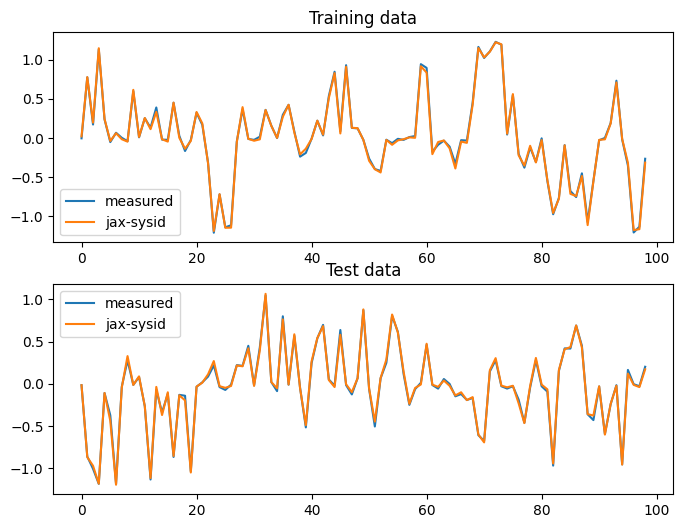

In [ ]:
# # eample_rnn.py

# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Nonlinear system identification example, using recurrent neural network based on flax.linen library.

# (C) 2024 A. Bemporad, March 6, 2024
# """
# from flax import linen as nn
# import matplotlib.pyplot as plt
# from jax_sysid.utils import standard_scale, unscale, compute_scores
# from jax_sysid.models import RNN, find_best_model
# import jax
# import numpy as np

# plotfigs = True  # set to True to plot figures

# # Data generation
# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# nx = 3  # number of states
# ny = 1  # number of outputs
# nu = 1  # number of inputs

# N_train = 1000  # number of training data
# N_test = 1000  # number of test data
# Ts = 1.  # sample time

# B = np.random.randn(nx, nu)
# C = np.random.randn(ny, nx)

# def truesystem(x0, U, D, qx, qy):
#     # system generating the training and test dataset
#     N_train = U.shape[0]
#     x = x0.copy()
#     Y = np.empty((N_train, ny))
#     X = np.empty((N_train, nx))
#     for k in range(N_train):
#         X[k] = x
#         Y[k] = np.arctan(C @ x**3) + qy * D[k,nx:]
#         x[0] = .5*np.sin(X[k,0]) + B[0, :]@U[k] * \
#             np.cos(X[k,1]/2.) + qx * D[k,0]
#         x[1] = .6*np.sin(X[k,0]+X[k,2]) + B[1, :]@U[k] * \
#             np.arctan(X[k,0]+X[k,1]) + qx * D[k,1]
#         x[2] = .4*np.exp(-X[k,1]) + B[2, :]@U[k] * \
#             np.sin(-X[k,0]/2.) + qx * D[k,2]
#     return Y, X

# qy = 0.01  # output noise std
# qx = 0.01  # process noise std
# U_train = np.random.rand(N_train, nu)-0.5
# D_train = np.random.randn(N_train, nx+ny)
# x0_train = np.zeros(nx)
# Y_train, _ = truesystem(x0_train, U_train, D_train, qx, qy)

# Ys_train, ymean, ygain = standard_scale(Y_train)
# Us_train, umean, ugain = standard_scale(U_train)

# U_test = np.random.rand(N_test, nu)-0.5
# D_test = np.random.randn(N_test, nx+ny)
# x0_test = np.zeros(nx)
# Y_test, _ = truesystem(x0_test, U_test, D_test, qx, qy)
# Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
# Us_test = (U_test-umean)*ugain

# # Perform system identification
# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations

# # state-update function
# class FX(nn.Module):
#     @nn.compact
#     def __call__(self, x):
#         x = nn.Dense(features=5)(x)
#         x = nn.swish(x)
#         x = nn.Dense(features=5)(x)
#         x = nn.swish(x)
#         x = nn.Dense(features=nx)(x)
#         return x

# # output function
# class FY(nn.Module):
#     @nn.compact
#     def __call__(self, x):
#         x = nn.Dense(features=5)(x)
#         x = nn.tanh(x)
#         x = nn.Dense(features=ny)(x)
#         return x


# model = RNN(nx, ny, nu, FX=FX, FY=FY, x_scaling=0.1)
# # L1+L2-regularization on initial state and model coefficients
# model.loss(rho_x0=1.e-4, rho_th=0., tau_th=4.e-4)
# # number of epochs for Adam and L-BFGS-B optimization
# model.optimization(adam_epochs=0, lbfgs_epochs=2000)

# train_single_model=True
# if train_single_model:
#     model.fit(Ys_train, Us_train)
#     t0 = model.t_solve
#     print(f"Elapsed time: {t0} s")
# else:
#     models=model.parallel_fit(Ys_train, Us_train, init_fcn=model.init_fcn, seeds=range(10))
#     model, best_R2 = find_best_model(models, Ys_test, Us_test, fit='R2')

# Yshat_train, _ = model.predict(model.x0, Us_train)
# Yhat_train = unscale(Yshat_train, ymean, ygain)

# # use RTS Smoother to learn x0
# x0_test = model.learn_x0(Us_test, Ys_test, RTS_epochs=10)
# Yshat_test, _ = model.predict(x0_test, Us_test)
# Yhat_test = unscale(Yshat_test, ymean, ygain)
# R2, R2_test, msg = compute_scores(
#     Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

# print(msg)
# print(model.sparsity_analysis())

# if plotfigs:
#     T_train = np.arange(N_train)*Ts
#     T_test = np.arange(N_test)*Ts
#     fig, ax = plt.subplots(2, 1, figsize=(8, 6))
#     ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
#     ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
#     ax[0].legend()
#     ax[0].set_title('Training data')
#     ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
#     ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
#     ax[1].legend()
#     ax[1].set_title('Test data')
#     plt.show()


In [ ]:
# # example_parallel_traning.py
# """
# jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

# Nonlinear system identification example using custom residual recurrent neural network model

#             x(k+1) = A*x(k) + B*u(k) + fx(x(k),u(k))
#               y(k) = C*x(k) + fy(x(k),u(k))

# (C) 2024 A. Bemporad, August 13, 2024
# """

# from jax_sysid.utils import standard_scale, unscale, compute_scores
# from jax_sysid.models import Model, LinearModel, StaticModel, RNN, find_best_model
# import jax
# import jax.numpy as jnp
# import numpy as np
# from joblib import cpu_count
# from flax import linen as nn
# from pmlb import fetch_data

# runNonlinearModel = True # Train custom recurrent NN model
# runRNNModel = False # Train RNN model using Flax
# runLinearModel = False # Train linear model
# runStaticModel = True # Train static model

# jax.config.update('jax_platform_name', 'cpu')
# if not jax.config.jax_enable_x64:
#     jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations

# seed = 3  # for reproducibility of results
# np.random.seed(seed)

# if runNonlinearModel or runRNNModel or runLinearModel:
#     nx = 3  # number of states
#     ny = 1  # number of outputs
#     nu = 1  # number of inputs

#     # Data generation
#     N_train = 10000  # number of training data
#     N_test = 1000  # number of test data
#     Ts = 1.  # sample time

#     B = np.random.randn(nx, nu)
#     C = np.random.randn(ny, nx)

#     def truesystem(x0, U, D, qx, qy):
#         # system generating the training and test dataset
#         N_train = U.shape[0]
#         x = x0.copy()
#         Y = np.empty((N_train, ny))
#         X = np.empty((N_train, nx))
#         for k in range(N_train):
#             X[k] = x
#             Y[k] = np.arctan(C @ x**3) + qy * D[k,nx:]
#             x[0] = .5*np.sin(X[k,0]) + B[0, :]@U[k] * \
#                 np.cos(X[k,1]/2.) + qx * D[k,0]
#             x[1] = .6*np.sin(X[k,0]+X[k,2]) + B[1, :]@U[k] * \
#                 np.arctan(X[k,0]+X[k,1]) + qx * D[k,1]
#             x[2] = .4*np.exp(-X[k,1]) + B[2, :]@U[k] * \
#                 np.sin(-X[k,0]/2.) + qx * D[k,2]
#         return Y, X

#     qy = 0.01  # output noise std
#     qx = 0.01  # process noise std
#     U_train = np.random.rand(N_train, nu)-0.5
#     D_train = np.random.randn(N_train, nx+ny)
#     x0_train = np.zeros(nx)
#     Y_train, _ = truesystem(x0_train, U_train, D_train, qx, qy)

#     Ys_train, ymean, ygain = standard_scale(Y_train)
#     Us_train, umean, ugain = standard_scale(U_train)

#     U_test = np.random.rand(N_test, nu)-0.5
#     D_test = np.random.randn(N_test, nx+ny)
#     x0_test = np.zeros(nx)
#     Y_test, _ = truesystem(x0_test, U_test, D_test, qx, qy)
#     Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
#     Us_test = (U_test-umean)*ugain

# if runNonlinearModel:
#     # Perform system identification
#     def sigmoid(x):
#         return 1. / (1. + jnp.exp(-x))

#     @jax.jit
#     def state_fcn(x, u, params):
#         A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
#         return A@x+B@u+W3@sigmoid(W1@x+W2@u+b1)+b2

#     @jax.jit
#     def output_fcn(x, u, params):
#         A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
#         return C@x+W5@sigmoid(W4@x+b3)+b4


#     model = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

#     nnx = 5  # number of hidden neurons in state-update function
#     nny = 5  # number of hidden neurons in output function


#     def init_fcn(seed):
#         np.random.seed(seed)
#         A = 0.5*np.eye(nx)
#         B = 0.1*np.random.randn(nx, nu)
#         C = 0.1*np.random.randn(ny, nx)
#         W1 = 0.1*np.random.randn(nnx, nx)
#         W2 = 0.5*np.random.randn(nnx, nu)
#         W3 = 0.5*np.random.randn(nx, nnx)
#         b1 = np.zeros(nnx)
#         b2 = np.zeros(nx)
#         W4 = 0.5*np.random.randn(nny, nx)
#         W5 = 0.5*np.random.randn(ny, nny)
#         b3 = np.zeros(nny)
#         b4 = np.zeros(ny)
#         return [A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4]


#     # initialize model coefficients
#     model.init(params=init_fcn(seed=1))
#     # L2-regularization on initial state and model coefficients
#     model.loss(rho_x0=1.e-4, rho_th=1.e-4)
#     # number of epochs for Adam and L-BFGS-B optimization
#     model.optimization(adam_epochs=0, lbfgs_epochs=2000)

#     models = model.parallel_fit(
#         Ys_train, Us_train, init_fcn=init_fcn, seeds=range(cpu_count()))

#     # Find model that achieves best fit on test data
#     best_model, best_R2 = find_best_model(models, Ys_test, Us_test, fit='R2')
#     print(f"\nBest R2-score achieved on test data = {best_R2}")

# if runRNNModel:
#     # state-update function
#     class FX(nn.Module):
#         @nn.compact
#         def __call__(self, x):
#             x1 = nn.Dense(features=5)(x)
#             x1 = nn.sigmoid(x1)
#             x1 = nn.Dense(features=nx)(x1)
#             x1 += nn.Dense(features=nx)(x) # linear bypass
#             return x1

#     # output function
#     class FY(nn.Module):
#         @nn.compact
#         def __call__(self, x):
#             y = nn.Dense(features=5)(x)
#             y = nn.sigmoid(y)
#             y = nn.Dense(features=ny)(y)
#             y += nn.Dense(features=ny)(x[:nx]) # linear bypass
#             return y

#     model = RNN(nx, ny, nu, FX=FX, FY=FY, x_scaling=0.1)

#     # L2-regularization on initial state and model coefficients
#     model.loss(rho_x0=1.e-4, rho_th=1.e-4)
#     # number of epochs for Adam and L-BFGS-B optimization
#     model.optimization(adam_epochs=1000, lbfgs_epochs=2000)

#     models=model.parallel_fit(Ys_train, Us_train, init_fcn=model.init_fcn, seeds=range(cpu_count()))

#     # Find model that achieves best fit on test data
#     best_model, best_R2 = find_best_model(models, Ys_test, Us_test, fit='R2')
#     print(f"\nBest R2-score achieved on test data = {best_R2}")

# if runLinearModel:
#     # Parallel training of linear models. 
#     # -----------------------------------
#     model = LinearModel(nx, ny, nu, feedthrough=False)
#     model.loss(rho_x0=1.e-3, rho_th=1.e-6)
#     # number of epochs for Adam and L-BFGS-B optimization
#     model.optimization(adam_epochs=0, lbfgs_epochs=1000)
#     models = model.parallel_fit(Ys_train, Us_train, seeds=range(cpu_count()))
    
#     best_model, best_R2 = find_best_model(models, Ys_test, Us_test, fit='R2')
#     print(f"\nBest R2-score achieved on test data = {best_R2}")

# if runStaticModel:
#     # Parallel training of static models:
#     U, Y = fetch_data("529_pollen", return_X_y=True)
#     tau_th = 0.002
#     zero_coeff = 1.e-4
#     Y = np.atleast_2d(Y).T

#     # Data generation
#     seed = 3  # for reproducibility of results
#     np.random.seed(seed)

#     ny = 1  # number of outputs
#     N, nu = U.shape  # nu = number of inputs

#     N_train = int(N*.75)  # number of training data
#     N_test = N-N_train  # number of test data

#     U_train = U[:N_train]
#     Y_train = Y[:N_train]

#     Ys_train, ymean, ygain = standard_scale(Y_train)
#     Us_train, umean, ugain = standard_scale(U_train)

#     U_test = U[N_train:]
#     Y_test = Y[N_train:]
#     Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
#     Us_test = (U_test-umean)*ugain


#     @jax.jit
#     def output_fcn(u, params):
#         W1, b1, W2, b2 = params
#         y = W1@u.T+b1
#         y = W2@jnp.arctan(y)+b2
#         return y.T


#     model = StaticModel(ny, nu, output_fcn)
#     n1 = 10  # number of neurons


#     def init_fcn(seed):
#         np.random.seed(seed)
#         W1 = np.random.randn(n1, nu)
#         b1 = np.random.randn(n1, 1)
#         W2 = np.random.randn(1, n1)
#         b2 = np.random.randn(1, 1)
#         return [W1, b1, W2, b2]


#     # L1+L2-regularization on initial state and model coefficients
#     model.loss(rho_th=1.e-4, tau_th=tau_th)
#     # number of epochs for Adam and L-BFGS-B optimization
#     model.optimization(adam_epochs=0, lbfgs_epochs=500)

#     seeds = range(cpu_count())
#     models = model.parallel_fit(Ys_train, Us_train, init_fcn=init_fcn, seeds=seeds)

#     id = 0
#     for model in models:
#         Yshat_train = model.predict(Us_train)
#         Yhat_train = unscale(Yshat_train, ymean, ygain)
#         Yshat_test = model.predict(Us_test)
#         Yhat_test = unscale(Yshat_test, ymean, ygain)
#         R2, R2_test, msg = compute_scores(
#             Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')
#         print(f"seed = {seeds[id]}: {msg}")
#         id += 1

# print("Parallel training done.")